# Classificação de imagens usando MLPs

Neste módulo do curso, vamos estudar Redes Neurais Convolucionais (CNNs). Essas redes tornaram-se famosas pela capacidade de realizar tarefas de classificação de imagens. Como vimos nas aulas teóricas, a rede AlexNet revolucionou o concurso ImageNet, desbancando todas as outras soluções por uma grande margem.

Antes de adentrarmos e testarmos as redes CNNs vamos ver como as tradicionais redes neurais, ou *multi-layer perceptrons* (MLPs) se saem em tarefas de classificação de imagens. Mais especificamente, vamos avaliar o desempenho de uma arquitetura relativamente simples de MLP no conjunto de dados [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

Vamos primeiro fazer algumas importações:

In [ ]:
import os
import numpy as np
import torch

from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision import transforms

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

%matplotlib inline

## Preparando o Dataloader

Utilizando o dataset padrão do MNIST disponibilizado pelo pacote torchvision. Para mais informações sobre o dataset, acesse a página: <https://pytorch.org/docs/stable/torchvision/datasets.html#mnist>.

Files already downloaded and verified


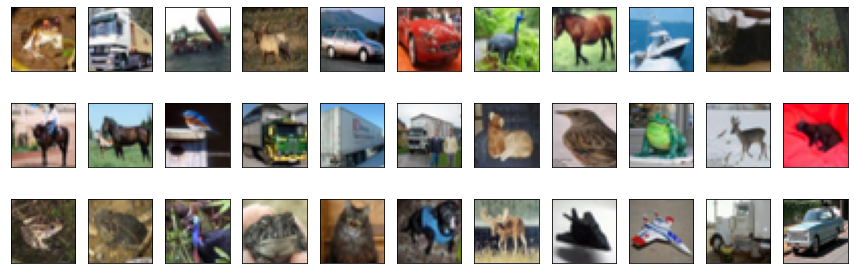

In [ ]:
# Definimos a transformação que vai ser aplicada aos dados: transformar em tensores
transf = transforms.Compose([transforms.ToTensor()])

# Vamos utilizar a implementação do CIFAR10 diretamente do Pytorch
train_set = datasets.CIFAR10('./', transform=transf, train=True, download=True)
test_set = datasets.CIFAR10('./', transform=transf, train=False, download=False)

# Plotando exemplos de imagens do conjunto de treino.
fig, ax = plt.subplots(3, 11, figsize=(15, 5))

idx = 0
for i in range(3):
    for j in range(11):

        ax[i][j].imshow(train_set[idx][0].numpy().transpose((1,2,0)).squeeze())
        ax[i][j].set_yticks([])
        ax[i][j].set_xticks([])
        idx += 1

plt.show()

Vamos dar uma olhada em nossos dados. Acho que você pode identificar facilmente algumas categorias aqui. Caminhões, carros, cavalos, sapos, gatos. Agora você sabe com o que estamos trabalhando. Estas são as imagens que queremos que nossa rede identifique. Apenas fornecendo os valores dos pixels na faixa RGB.

In [ ]:
# Para gerar o conjunto de validação, vamos separar 10% do conjunto de treino
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_set)), # índice das N imagens do dataset
    train_set.targets, # rótulos das imagens
    stratify=train_set.targets, #  os rótulos serão usados pela função para fazer uma divisão proporcional entre as classes
    test_size=0.1, # separamos 10% do conjunto para a validação
    random_state=42
)

# Geramos um subsets dos dados conforme os índices gerados pelo split
train_split = Subset(train_set, train_indices)
val_split = Subset(train_set, val_indices)

# Criando os dataloaders
batch_size = 32

train_loader = DataLoader(train_split, batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

print('Número de mini-batches no treino: ', len(train_loader))
print('Número de mini-batches na validação: ', len(val_loader))
print('Número de mini-batches no teste: ', len(test_loader))

Número de mini-batches no treino:  1407
Número de mini-batches na validação:  157
Número de mini-batches no teste:  313


## Definindo a arquitetura da rede

### Exercício 1

O pacote torch.nn que contém as implementações de todas as camadas que serão usadas nessa parte (nn.Linear): <https://pytorch.org/docs/stable/nn.html>.

Vamos definir uma arquitetura com as seguintes características:

* Uma camada de Flatten que recebe cada imagem como uma matriz 32x32x3, achatando em um vetor de comprimento 3072. Sem parâmetros treináveis ​​aqui, isso está preparando a imagem para nossas camadas densas.

* Uma primeira camada densa (fully connected ou Linear) com 1000 neurônios. Isso significa que cada um dos 3.072 valores de x será multiplicado por 1000 pesos  (porque uma camada densa é totalmente conectada, então cada nó em uma camada será conectado a cada nó na próxima camada). Incluindo os viéses, temos 3.073 pesos por neurônio, que resultarão em 3.073.000 parâmetros. São 3073000 pesos prontos para serem treinados. Vamos utilizar um ReLU como função de ativação.

* Então temos nossa primeira camada de `dropout`, com uma probabilidade de 20%.

* Em seguida, outra camada densa de tamanho 512, na qual cada um dos 512 nós receberá os 1000 valores de saída da camada anterior, fornecendo 512x1001=512512 parâmetros treináveis. Isso está começando a somar, você não acha ..? Vamos utilizar ReLU como função de ativação novamente.

* Outro `dropout`, a julgar pela quantidade de parâmetros, acho que você entendeu por que é bom usar.

* A última camada densa é a nossa camada de saída. Temos 10 categorias, então 10 neurônios, cada um produzindo a probabilidade de uma imagem estar nessa categoria. Assim, nossos 512 (+ viés) parâmetros são lançados em cada um deles, dando-nos 10x513=5130 pesos prontos para serem otimizados.

Somando tudo isso resultará na quantidade de parâmetros que são tão bem resumidos para você pelo Pytorch. Acho que você concorda que é MUITO trabalho a ser feito. Começando a ver o problema?

In [ ]:
import torch.nn as nn
from torchsummary import summary

class CustomNetwork(nn.Module):

    def __init__(self, input_size, n_classes):

        super(CustomNetwork, self).__init__()

        self.n_outputs_1 = 1000
        self.n_outputs_2 = 512

        self.flat = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(input_size, self.n_outputs_1),       # Fully Connected Layer: 3072 -> 1000.
                   nn.ReLU(inplace=True),                         # ReLU Activation Layer.
                   nn.Dropout(p=0.2),                             # Dropout

                   nn.Linear(self.n_outputs_1, self.n_outputs_2), # Fully Connected Layer: 1000 -> 512.
                   nn.ReLU(inplace=True),                         # ReLU Activation Layer.
                   nn.Dropout(p=0.2),                             # Dropout

                   nn.Linear(self.n_outputs_2, n_classes))        # Fully Connected Layer: 512 -> 10.

    def forward(self, x):
        x = self.flat(x)
        # print('input', x.size()) # Comment this line for less text during execution.
        out = self.fc(x)
        # print('out', out.size()) # Comment this line for less text during execution.

        return out

input_size = 3072 # Input size (32*32*3)
n_classes = 10 # Number of classes on CIFAR10

model = CustomNetwork(input_size, n_classes).cuda()

print(model)
summary(model, (3, 32, 32))

CustomNetwork(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=3072, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1000, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 1000]       3,073,000
              ReLU-3                 [-1, 1000]               0
           Dropout-4                 [-1, 1000]               0
            Linear-5                  [-1, 512]         512,512
              ReLU-6                  [-1, 512]               0
           Dropout-7                  [-1, 512]               0
            Linea

## Definindo o otimizador

O *Pytorch* tem várias opções de otimizadores, desde os mais simples como o SGD até otimizadores mais modernos com velocidades de aprendizado adaptáveis para cada parâmetro da rede (i.e. Adam, Adagrad, RSMProp...). Todos os otimizadores estão localizados no pacote torch.optim. Para mais informnações sobre o pacote, visite: <https://pytorch.org/docs/stable/optim.html>. Vamos utilizar o Adam com learning rate de 0.001 nesse exemplo.

In [ ]:
import torch.optim as optim

lr = 0.001
optimizer = optim.Adam(params=model.parameters(), lr=lr)

## Definindo a função de perda

Definindo um critério (loss) de classificação para calcular o erro do seu modelo a cada batch de amostras. A *CrossEntropyLoss* ou a *NLLLoss* são funções de perda indicadas para esse tipo de tarefa. Informações sobre essas losses podem ser encontradas em: <https://pytorch.org/docs/stable/nn.html#loss-functions>. Vamos usar a CrossEntropy nesse exemplo.

In [ ]:
criterion = nn.CrossEntropyLoss().cuda()

## Treino e validação

Iterando sobre batches de treino e validação ao longo de várias epochs.

In [ ]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

%matplotlib inline

epochs = 5

train_loss = np.zeros(epochs)
train_acc = np.zeros(epochs)
val_loss = np.zeros(epochs)
val_acc = np.zeros(epochs)

for ep in range(epochs):

    print('##############################################')
    print('Starting epoch ' + str(ep + 1) + '/' + str(epochs) + '...')

    print('Training...')

    # Colocando o modelo no modo de treinamento
    model.train()

    training_metrics = list()
    val_metrics = list()

    train_label_list = list()
    train_output_list = list()

    # Iterando nos batches de treino
    for it, data in enumerate(train_loader):

        # Obtendo o dado (inps) e rótulo (labs) do batch
        inps, labs = data

        # GPU casting
        inps = inps.cuda()
        labs = labs.cuda()

        # Zerando o otimizador
        optimizer.zero_grad()

        # Realizando o forward
        output = model(inps)

        # Computando a loss
        loss = criterion(output, labs)

        # Realizando o Backpropagation
        loss.backward()

        # Atualizando os pesos da rede
        optimizer.step()

        # Adicionando a loss do batch na lista
        training_metrics.append(loss.detach().cpu().numpy())

        # Pegando a previsão e o label do batch para calculo da acurácia ao final da época
        train_label_list += labs.cpu().numpy().tolist()
        train_output_list += output.max(1)[1].cpu().numpy().tolist()

    # Calculando a acurácia de treino na época
    train_label_array = np.asarray(train_label_list, dtype=np.int32).ravel()
    train_output_array = np.asarray(train_output_list, dtype=np.int32).ravel()
    accuracy = np.sum(train_label_array == train_output_array) / float(train_label_array.shape[0])
    print('\tTrain Accuracy: %.2f%%' % (100.0 * accuracy))

    # Adicionando a acurácia e loss aos respectivos arrays para plotar no final do treino
    train_acc[ep] = accuracy
    train_loss[ep] = np.asarray(training_metrics).ravel().mean()

    print('Validation...')

    # Colocando o modelo no modo de validação
    model.eval()

    with torch.no_grad():

        label_list = list()
        output_list = list()

        # Iterando sobre os batches de validação
        for it, data in enumerate(val_loader):

            # Obtendo o dado e rótulo do batch
            inps, labs = data

            # GPU casting
            inps = inps.cuda()
            labs = labs.cuda()

            # Forward
            output = model(inps)

            # Computando a loss
            loss = criterion(output, labs)

            # Adicionando a loss do batch na lista
            val_metrics.append(loss.detach().cpu().numpy())

            # Pegando a previsão e rótulo do batch para cálculo de acurácia
            label_list += labs.cpu().numpy().tolist()
            output_list += output.max(1)[1].cpu().numpy().tolist()

        # Calculando a acurácia da validação na época
        label_array = np.asarray(label_list, dtype=np.int32).ravel()
        output_array = np.asarray(output_list, dtype=np.int32).ravel()
        accuracy = np.sum(label_array == output_array) / float(label_array.shape[0])
        print('\tValidation Accuracy: %.2f%%' % (100.0 * accuracy))

        # Adicionando acurácia e loss aos respectivos arrays para plotar no final
        val_acc[ep] = accuracy
        val_loss[ep] = np.asarray(val_metrics).ravel().mean()

##############################################
Starting epoch 1/5...
Training...
	Train Accuracy: 29.26%
Validation...
	Validation Accuracy: 30.60%
##############################################
Starting epoch 2/5...
Training...
	Train Accuracy: 34.35%
Validation...
	Validation Accuracy: 35.24%
##############################################
Starting epoch 3/5...
Training...
	Train Accuracy: 36.02%
Validation...
	Validation Accuracy: 39.68%
##############################################
Starting epoch 4/5...
Training...
	Train Accuracy: 37.10%
Validation...
	Validation Accuracy: 40.24%
##############################################
Starting epoch 5/5...
Training...
	Train Accuracy: 38.61%
Validation...
	Validation Accuracy: 41.50%


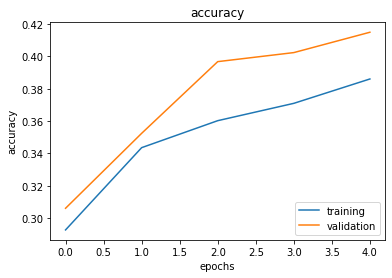

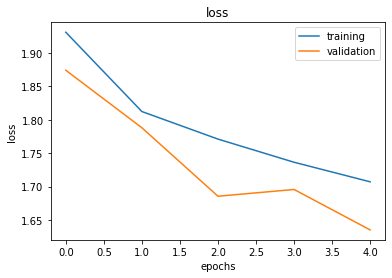

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Aqui, visualizamos nosso processo de treinamento. Basicamente, esse tipo de visualização pode ser útil para identificar rapidamente o ponto exato em que passamos nosso ponto de ouro e começamos a ajustar demais ao nosso conjunto de treinamento. Eu diria que, com apenas 5 épocas, não há muito que concluir além de "talvez seja necessário aumentar o número de épocas".

## Teste do modelo

Então, depois de fazer todo o processo de treinamento, avaliamos o modelo com esses pesos em relação a dados que ele nunca viu antes, ou seja, o conjunto de teste.

Iterando sobre os batchs de teste para obter a acurácia do modelo no conjunto de teste:

In [ ]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

%matplotlib inline

print('Test...')

model.eval()

with torch.no_grad():

    label_list = list()
    output_list = list()

    for it, data in enumerate(test_loader):
        inps, labs = data

        inps = inps.cuda()
        labs = labs.cuda()

        output = model(inps)

        label_list += labs.cpu().numpy().tolist()
        output_list += output.max(1)[1].cpu().numpy().tolist()

    label_array = np.asarray(label_list, dtype=np.int32).ravel()
    output_array = np.asarray(output_list, dtype=np.int32).ravel()

    accuracy = np.sum(label_array == output_array) / float(label_array.shape[0])
    print('Test Accuracy: %.2f%%' % (100.0 * accuracy))

Test...
Test Accuracy: 42.44%


Vamos fazer o forward de uma imagem aleatória do teste para visualizar a predição.

Image shape:  torch.Size([3, 32, 32])
Image shape after unsqueeze:  torch.Size([1, 3, 32, 32])
Prediction:  9  | Label:  9


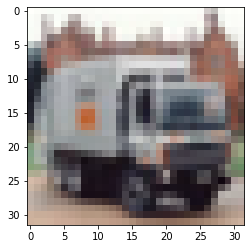

In [ ]:
id_img = 11
img, label = test_set[id_img]
plt.imshow(img.numpy().transpose((1,2,0)))
print('Image shape: ', img.shape)
img = img.unsqueeze(0)
print('Image shape after unsqueeze: ', img.shape)
img = img.cuda()
predicao = model(img)
print('Prediction: ', predicao.max(1)[1].cpu().item(), ' | Label: ', label)

# A operação de convolução

### Convolução da imagem do zero

Operação matemática em duas funções que produz uma terceira função representando como a forma de uma é modificada pela outra.

![Image convolution — kernel filtering](https://miro.medium.com/max/728/1*Fr6Umze2waDjWVHB2yzT4A.png)


A ideia por trás da convolução é estudar como uma função quando mapeada com outra função traz uma nova função modificada. Quando o mesmo é aplicado aos sinais é chamado de convolução 1d, às imagens — convolução 2d e aos vídeos — convolução 3d. Vamos concentrar na convolução 2d.

### Visão geral

Podemos pensar em uma imagem como uma matriz bidimensional contendo valores de cor de pixel na faixa de 0 a 255. Matematicamente, podemos manipular essa matriz aplicando várias operações de matriz.
Usaremos [OpenCV](http://bit.ly/2R8Auux) (uma biblioteca flexível para processamento de imagens), NumPy para operações de matrizes e arrays e Matplotlib para plotar as imagens.

### Exemplo

Usamos o objeto `imread()` para ler a imagem. Por padrão `cv2.imread()` lê a imagem no formato Azul, Verde e Vermelho. Precisamos convertê-lo para o formato Vermelho, Azul e Verde.

Usaremos a clássica imagem da modelo sueca *Lena Forsén* durante os exercícios seguintes. Para salvar essa imagem na pasta atual deste notebook, execute o código abaixo:

In [ ]:
import requests

img_data = requests.get("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png").content
with open('lena.png', 'wb') as handler:
    handler.write(img_data)

Se a imagem estiver disponível, podemos começar a trabalhar...

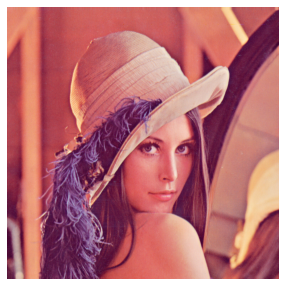

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

src = cv2.imread('lena.png')
img = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.imshow(img)

### Imagem para matriz

Para esses exercícios, consideraremos valores de matriz de uma imagem em escala de CINZA onde cada pixel contém valores entre 0 e 255. O problema com a imagem colorida é que cada valor de pixel é uma combinação de 3 valores provavelmente na forma de [R, G, B] ou [B, G, R] o que pode tornar o cálculo complicado. Então, para manter as coisas simples, pegamos uma imagem em escala de CINZA.

Se visualizarmos a matriz, veremos que ela contém valores de pixel no intervalo de 0 a 255.

In [ ]:
img = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
plt.imsave('lena_gray.png', img, cmap='gray')
img_mat = cv2.imread('lena_gray.png', 0)
print(img_mat)
print(img_mat.shape)

[[159 159 159 ... 168 151 119]
 [159 159 159 ... 168 151 119]
 [159 159 159 ... 168 151 119]
 ...
 [ 20  20  29 ...  91  87  84]
 [ 22  22  34 ...  91  93  96]
 [ 22  22  34 ...  91  93  96]]
(512, 512)


Vamos transpor a matriz acima e ver se a imagem é transposta.

In [ ]:
img_tran_mat = img_mat.T
print(img_tran_mat)
print(img_tran_mat.shape)

[[159 159 159 ...  20  22  22]
 [159 159 159 ...  20  22  22]
 [159 159 159 ...  29  34  34]
 ...
 [168 168 168 ...  91  91  91]
 [151 151 151 ...  87  93  93]
 [119 119 119 ...  84  96  96]]
(512, 512)


Você vê a diferença entre a matriz original e a matriz transposta? Agora salve a matriz como uma imagem usando o método `imwrite()` — que lê a matriz e os números e escreve como uma imagem.

In [ ]:
cv2.imwrite('lena_gray_tran.png', img_tran_mat)

True

Vamos ver a diferença...

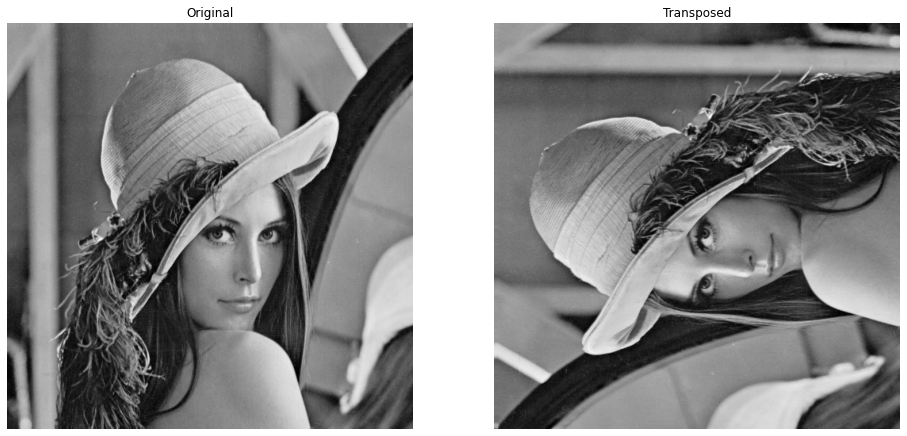

In [ ]:
fig = plt.figure(figsize=(16, 25))

orig = cv2.imread('lena_gray.png')
tran = cv2.imread('lena_gray_tran.png')

ax1 = fig.add_subplot(2,2,1)
ax1.axis("off")
ax1.title.set_text('Original')
ax1.imshow(orig)

ax2 = fig.add_subplot(2,2,2)
ax2.axis("off")
ax2.title.set_text('Transposed')
ax2.imshow(tran)

Obtemos uma imagem totalmente transposta e é por causa da matriz transposta que realizamos anteriormente.

Para convolução, exigimos um filtro de kernel separado que é operado em toda a imagem, resultando em uma imagem completamente modificada.

$g(x, y) = w * f(x, y)$,

onde $w$ = kernel, $g$ = resultado e $f$ = entrada

No processamento de imagens; kernel, matriz de convolução ou máscara, é uma pequena matriz usada para desfoque, nitidez, relevo, detecção de borda e muito mais. Isso é feito fazendo uma convolução entre um kernel e uma imagem.

### Etapas para convolução de imagens

1. Converta a imagem em tons de cinza e obtenha a matriz.

2. Obtenha uma matriz gigante contendo sub-matrizes de tamanho kernel da matriz original.

3. Execute uma convolução fazendo uma multiplicação elemento a elemento entre o kernel e cada submatriz e some o resultado em um único inteiro ou valor flutuante. Ao fazer isso, obtenha uma matriz transformada ou filtrada.

4. Converta a matriz transformada ou filtrada em uma imagem.


### Exercício 2

Implemente funções para executar as operações descritas nos passos 2 e 3 anteriormente.

1. Converta a imagem em tons de cinza e obtenha a matriz.

In [ ]:
def convert_image_matrix(img_name):
    src = cv2.imread(img_name)
    img = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    name, ext = img_name.split('.')
    plt.imsave(str(name + '_gray.' + ext), img, cmap='gray')

    gray_img = cv2.imread(str(name + '_gray.' + ext), 0)

    return gray_img

A função acima retorna um array 2Dimentional NumPy contendo os valores de pixel.

2. Obtenha uma matriz gigante contendo sub-matrizes de tamanho kernel da matriz original.

In [ ]:
def get_sub_matrices(orig_matrix, kernel_size):
    width = len(orig_matrix[0])
    height = len(orig_matrix)

    giant_matrix = []
    for i in range(0, height - kernel_size[1] + 1):
        for j in range(0, width - kernel_size[0] + 1):
            giant_matrix.append(
                [
                    [orig_matrix[col][row] for row in range(j, j + kernel_size[0])]
                    for col in range(i, i + kernel_size[1])
                ]
            )
    img_sampling = np.array(giant_matrix)
    return img_sampling

A função acima retorna uma matriz gigante contendo sub-matrizes do tamanho do kernel que serão usadas novamente mais tarde. A matriz resultante também pode ser chamada de matriz amostrada.

3. Execute uma convolução fazendo uma multiplicação elemento a elemento entre o kernel e cada submatriz e some o resultado em um único inteiro ou valor flutuante. Ao fazer isso, obtenha uma matriz transformada ou filtrada.

In [ ]:
def get_transformed_matrix(matrix_sampling, kernel_filter):
    transform_mat = []
    for each_mat in matrix_sampling:
        transform_mat.append(
            np.sum(np.multiply(each_mat, kernel_filter))
        )
    reshape_val = int(math.sqrt(matrix_sampling.shape[0]))
    transform_mat = np.array(transform_mat).reshape(reshape_val, reshape_val)
    return transform_mat

A matriz gigante ou a matriz amostrada é passada como argumento junto com o filtro do kernel na função acima para realizar a convolução.

4. Converta a matriz transformada ou filtrada em uma imagem.

In [ ]:
def original_VS_convoluted(img_name, kernel_name, convoluted_matrix):
    name, ext = img_name.split('.')
    cv2.imwrite(str(name + '_' + kernel_name + '.' + ext), convoluted_matrix)
    orig = cv2.imread(str(name + '_gray.' + ext))
    conv = cv2.imread(str(name + '_' + kernel_name + '.' + ext))

    fig = plt.figure(figsize=(16, 25))
    ax1 = fig.add_subplot(2,2,1)
    ax1.axis("off")
    ax1.title.set_text('Original')
    ax1.imshow(orig)
    ax2 = fig.add_subplot(2,2,2)
    ax2.axis("off")
    ax2.title.set_text(str(kernel_name).title())
    ax2.imshow(conv)
    return True

A função acima é uma função de plotagem que compara a imagem original com a imagem transformada após a convolução.

### Exercício 3

Execute as seguintes operações de convolução na imagem da Lena:

* Operação de identidade

* Operação de detecção de bordas

* Operação de nitidez

* Operação de desfoque de caixa

* Operação de desfoque Gaussiano

#### Tipos de convoluções

Temos vários tipos de operações de convolução que podem ser aplicadas a uma imagem. Alguns deles são:

* **Operação de identidade**: Função que retorna o mesmo valor que é usado como argumento.

$f(x) = x;$

kernel = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

True

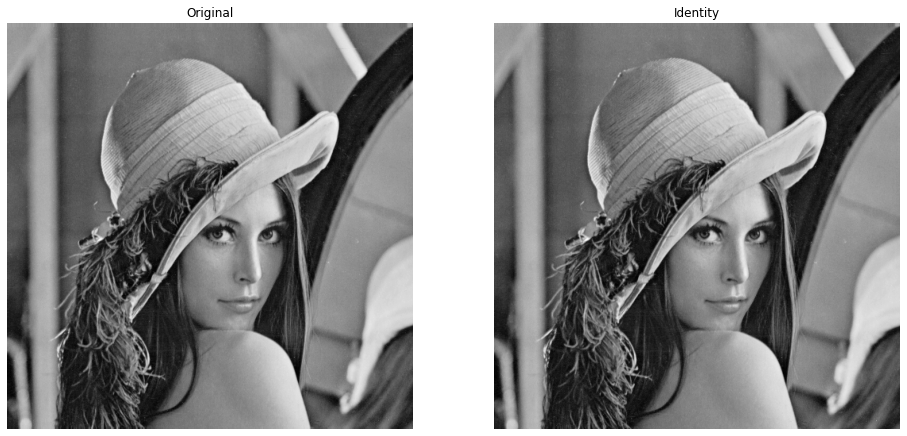

In [ ]:
img_name = 'lena.png'
img_mat = convert_image_matrix(img_name)
identity_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])
img_sampling = get_sub_matrices(img_mat, identity_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, identity_kernel)
original_VS_convoluted(img_name,'identity', transform_mat)

Do resultado acima, fica claro que não há diferença entre a imagem original e a transformada.

* **Operação de detecção de bordas**: A função inclui uma variedade de métodos matemáticos que visam identificar pontos em uma imagem digital para os quais o brilho da imagem muda. A técnica do detector de bordas de Canny funciona de forma eficaz.

kernel = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]

True

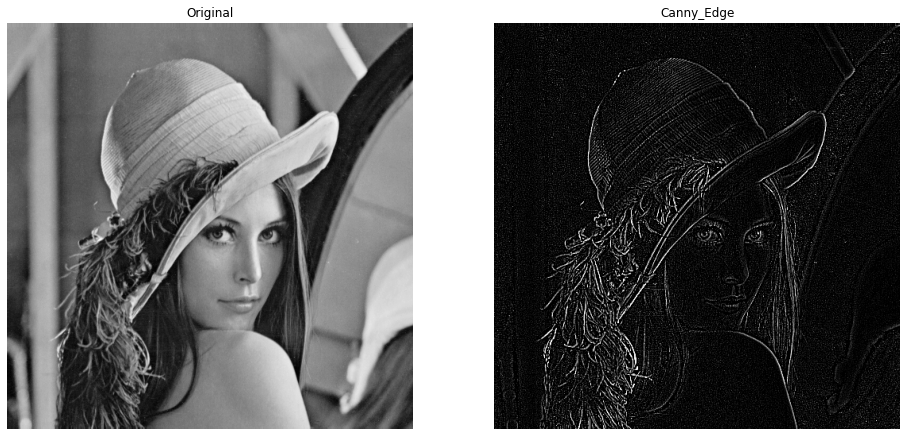

In [ ]:
img_name = 'lena.png'
img_mat = convert_image_matrix(img_name)
canny_edge_kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
img_sampling = get_sub_matrices(img_mat, canny_edge_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, canny_edge_kernel)
original_VS_convoluted(img_name,'canny_edge', transform_mat)

A partir do resultado acima, podemos dizer que as bordas estão sendo destacadas em branco e o resto tudo é preto. O algoritmo foi capaz de identificar as bordas de detalhes específicos, como olhos e cabelos. No entanto, existem outros tipos de algoritmos de detecção de borda.

* **Operação de nitidez**: A função aumenta o contraste entre as regiões claras e escuras da imagem.

kernel = [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]

True

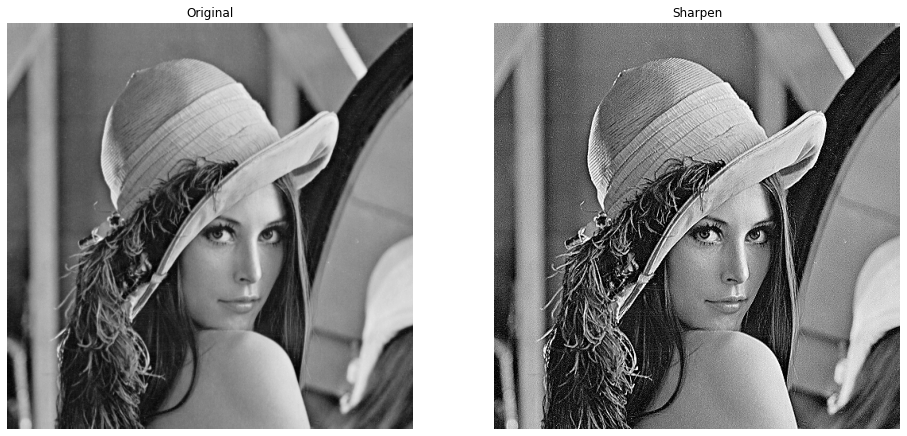

In [ ]:
img_name = 'lena.png'
img_mat = convert_image_matrix(img_name)
sharpen_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
img_sampling = get_sub_matrices(img_mat, sharpen_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, sharpen_kernel)
original_VS_convoluted(img_name,'sharpen', transform_mat)

Pelo resultado acima, fica claro que a imagem transformada persiste algum tipo de ruído e também vemos que as áreas mais claras ficaram ainda mais brilhantes e também as áreas mais escuras ficaram ainda mais escuras.

* **Operação de desfoque de caixa**: a função é um tipo de filtro linear em que cada pixel na imagem resultante tem um valor igual ao valor médio de seus pixels vizinhos na imagem de entrada.

kernel = (1/9) * [[1, 1, 1], [1, 1, 1], [1, 1, 1]]

True

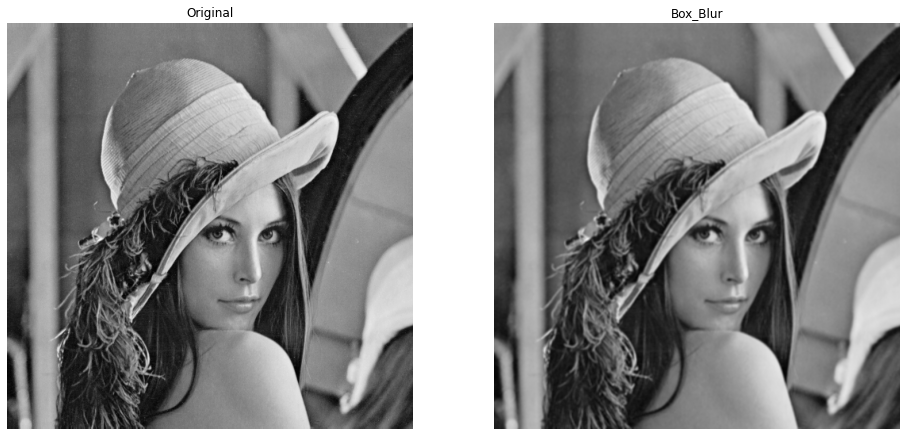

In [ ]:
img_name = 'lena.png'
img_mat = convert_image_matrix(img_name)
box_blur_kernel = (1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]])
img_sampling = get_sub_matrices(img_mat, box_blur_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, box_blur_kernel)
original_VS_convoluted(img_name,'box_blur', transform_mat)

A partir do resultado, notamos que a imagem transformada é ligeiramente mais suave que a imagem original. Como sabemos agora, quando o kernel é operado com as submatrizes, o resultado da soma é imediatamente calculado e, assim, deixando-o com um valor normalizado.

* **Operação de desfoque gaussiano**: A função também é conhecida como função de suavização gaussiana normalmente usada para reduzir o ruído da imagem.

kernel = (1/16) * [[1, 2, 1], [2, 4, 2], [1, 2, 1]]

True

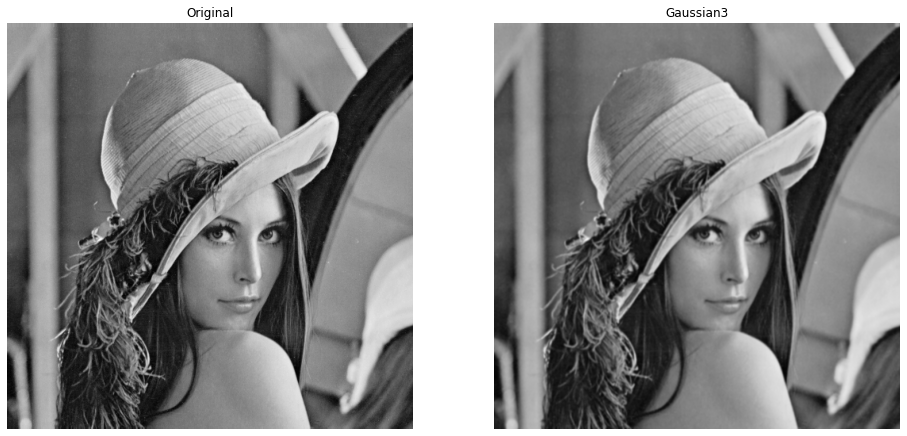

In [ ]:
img_name = 'lena.png'
img_mat = convert_image_matrix(img_name)
gaussian3_kernel = (1/16)*np.array([[1,2,1],[2,4,2],[1,2,1]])
img_sampling = get_sub_matrices(img_mat, gaussian3_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, gaussian3_kernel)
original_VS_convoluted(img_name,'gaussian3', transform_mat)

### Conclusão

A convolução é uma operação matemática simples que é fundamental para muitos operadores comuns de processamento de imagens.

Tem várias aplicações no campo da matemática, como probabilidade e estatística, sistemas lineares, etc.

# Padding

A operação de convolução que vimos tem um pequeno problema: a imagem convolvida terá dimensões menores que a imagem original. Não percebemos isso porque a imagem utilizada é de alta resolução. Se testarmos as funções em imagens menores, essa perda ficará nítida.

Assim, vamos executar a função anterior em imagens da coleção `CIFAR10`. Um arquivo contendo as 100 primeiras imagens desse conjunto pode ser baixado através [deste link](https://www.dropbox.com/s/qrfb8q7bzo47i2q/cifar10.zip?dl=0). Faça o download do zip e extraia o seu conteúdo para a pasta deste notebook. Depois disso, vamos testar uma convolução do tipo *identidade* em uma das imagens.

### Exercício 4

Execute a operação de identidade na figura `8.png` do conjunto CIFAR10.

In [ ]:
img_8 = (train_set[7][0].numpy()*255).transpose((1,2,0))
cv2.imwrite('8.png',img_8)

True

True

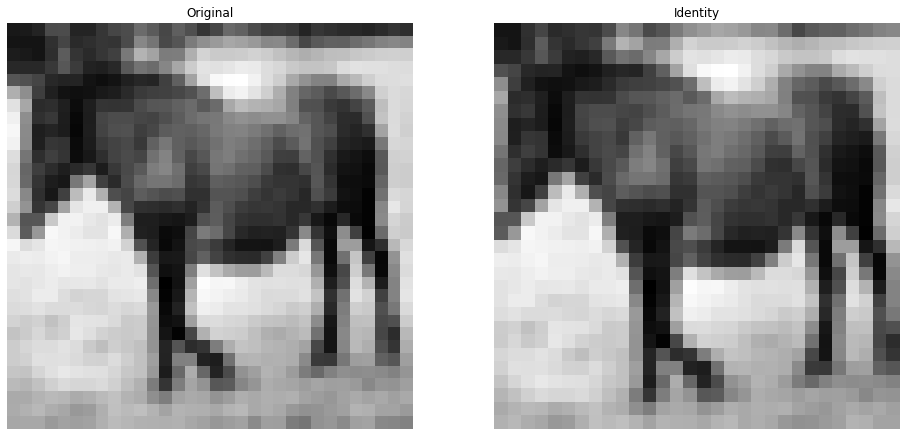

In [ ]:
img_name = '8.png'
img_mat = convert_image_matrix(img_name)
identity_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])
img_sampling = get_sub_matrices(img_mat, identity_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, identity_kernel)
original_VS_convoluted(img_name,'identity', transform_mat)

Note que a imagem convolvida é idêntica à original, mas sem as bordas extremas. Até que a perda é pequena, mas se muitas operações de convolução forem feitas de forma consecutiva, a imagem pode ficar muito pequena, ocasionando uma grande perda de informação.

Para resolver esse problema, podemos realizar uma operação de *0-padding*, que adiciona `p` bordas adicionais com valores 0 à imagem original antes da operação de convolução. Embora a operação *0-padding* seja a operação padrão, e muitas vezes simplesmente chamada de *padding*, outras formas de preencher as bordas existem.

Vamos implementar abaixo uma função para adicionar `p` bordas com zeros à uma imagem.

### Exercício 5

Implemente uma função para adicionar `p` bordas com zeros à uma imagem.

In [ ]:
def add_padding(matrix: np.ndarray, padding: int) -> np.ndarray:
    """Adds padding to the matrix.
    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding int: number of rows and columns to be padded. With the `p` padding we addding `p` rows to the top and bottom and `p` columns to the left and to the right of the matrix
    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * p, m + 2 * p`.
    """
    n, m = matrix.shape
    p = padding

    padded_matrix = np.zeros((n + p * 2, m + p * 2))
    padded_matrix[p : n + p, p : m + p] = matrix

    return padded_matrix


Sabendo que perdemos uma borda inteira de tamanho 1 pixel sem realizar o *padding*, vamos repetir a operação de convolução e adicionar exatamente um *padding* de tamanho 1.

### Exercício 6

Execute um padding de tamanho 1 na imagem `8.png` do conjunto CIFAR10 e depois realize a operação de convolução *identidade*. O tamanho da imagem convolvida se alterou?

True

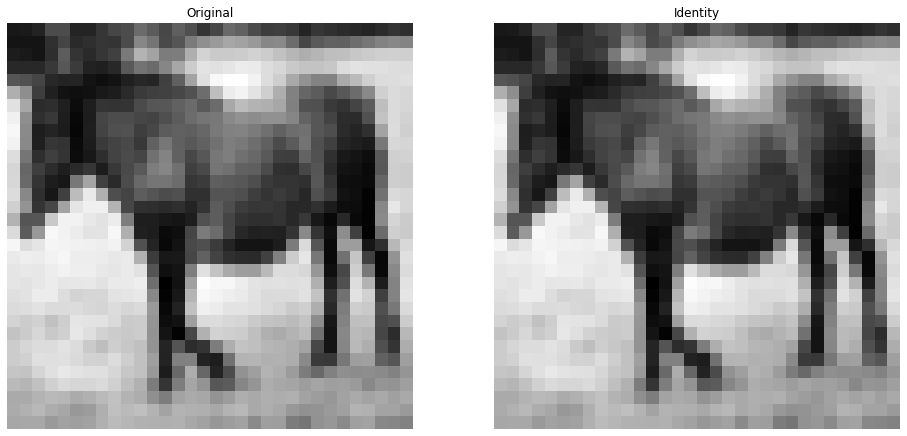

In [ ]:
img_name = '8.png'
img_mat = convert_image_matrix(img_name)
img_mat = add_padding(img_mat, 1)
identity_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])
img_sampling = get_sub_matrices(img_mat, identity_kernel.shape)
transform_mat = get_transformed_matrix(img_sampling, identity_kernel)
original_VS_convoluted(img_name,'identity', transform_mat)

Como esperado, a operação de identidade ficou perfeita, sem perda de informações.